# BMW car pricing

## Libraries

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns

## Import Data

In [151]:
df = pd.read_csv(r'C:\Users\Jordi Grau\Desktop\Data Science Project\BMW_Regression-1\bmw_pricing_v2.csv', sep=',')

In [152]:
df

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,BMW,118,140411.0,100.0,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400.0,2018-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,BMW,218 Gran Tourer,39743.0,110.0,2015-10-01,diesel,black,van,False,True,False,False,False,False,True,False,14600.0,2018-08-01
4839,BMW,218 Active Tourer,49832.0,100.0,2015-06-01,diesel,grey,van,False,True,False,False,False,False,True,True,17500.0,2018-08-01
4840,BMW,218 Gran Tourer,19633.0,110.0,2015-10-01,diesel,grey,van,False,True,False,False,False,False,True,True,17000.0,2018-09-01
4841,BMW,218 Active Tourer,27920.0,110.0,2016-04-01,diesel,brown,van,True,True,False,False,False,False,True,True,22700.0,2018-09-01


# Functions

In [153]:
def plot_cat_values(dataframe, column, target_column):

  plt.figure(figsize=(15, 8))

  ax1 = plt.subplot(2, 1, 1)
  ax1 = sns.countplot(dataframe[column], order = list(dataframe[column].unique()))

  ax2 = plt.subplot(2, 1, 2)
  ax2 = sns.boxenplot(data=dataframe[dataframe[target_column]>0], x=column, y=target_column, order = list(dataframe[column].unique()))

  plt.show()

In [154]:
def explore_cat_values(dataframe, column, target_column):
  results_df = dataframe[dataframe[target_column]>0].pivot_table( index = column, values = TARGET_LN, aggfunc = [len, np.mean])
  results_df.columns = ['cars_bought', 'mean_price_ln']
  results_df['n_rows'] = dataframe[column].value_counts(dropna = False)
  results_df['pct_rows'] = dataframe[column].value_counts(dropna = False, normalize = True)
  results_df['pct_cars_bought'] = results_df['cars_bought']  / results_df['n_rows']
  return results_df[['n_rows', 'pct_rows', 'cars_bought','pct_cars_bought', 'mean_price_ln']]

In [155]:
def set_Bot_Others(dataframe, column, num_values):
  top_cat_list = dataframe[column].value_counts().head(num_values).index.to_list()
  top_cat_list.append('Others')
  dataframe[column] = pd.Categorical(dataframe[column], categories = top_cat_list )
  return dataframe[column].fillna('Others')

# EDA

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        4841 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               4842 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4831 non-null   object 
 7   tipo_coche                   4834 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4841 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  4839 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

In [157]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Columns: 18 entries, marca to fecha_venta
dtypes: bool(1), float64(3), object(14)
memory usage: 648.1+ KB


In [158]:
description = df.describe(include='all').T

In [159]:
description.to_excel('df_description.xlsx')

# Analisis del Target

In [160]:
TARGET = 'precio'

In [161]:
df[TARGET].describe()

count      4837.000000
mean      15831.920612
std        9222.630708
min         100.000000
25%       10800.000000
50%       14200.000000
75%       18600.000000
max      178500.000000
Name: precio, dtype: float64

D:\DS\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='precio', ylabel='Density'>

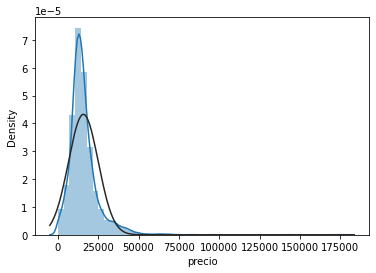

In [162]:
sns.distplot(df[TARGET], fit = stats.norm)

In [163]:
df['TARGET_LN'] = df[TARGET].apply(lambda x: np.log10(x))

D:\DS\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TARGET_LN', ylabel='Density'>

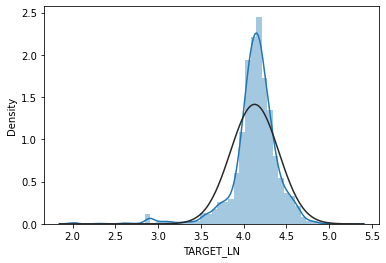

In [164]:
sns.distplot(df['TARGET_LN'], fit = stats.norm)

In [165]:
TARGET_LN = 'TARGET_LN'

# Data Understanding

## Categoricas

### Marca

In [166]:
df['marca'].value_counts(dropna = False)

BMW    4841
NaN       2
Name: marca, dtype: int64

In [167]:
df[df['marca'].isnull()]

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta,TARGET_LN
161,NaN,520,246424.0,120.0,2010-07-01,diesel,black,estate,True,True,False,False,False,False,True,False,6000.0,2018-08-01,3.778151
210,NaN,320,163879.0,120.0,2012-03-01,diesel,grey,estate,False,False,False,False,False,False,True,False,8600.0,2018-06-01,3.934498


In [168]:
df['marca'].fillna('BMW', inplace = True)

### Modelo

In [169]:
df['modelo'].value_counts(dropna = True)

320                752
520                633
318                568
X3                 438
116                358
                  ... 
M135                 1
225                  1
i8                   1
630                  1
214 Gran Tourer      1
Name: modelo, Length: 76, dtype: int64

In [170]:
df['modelo'].nunique()

76

In [171]:
df['modelo'].fillna('Others_null', inplace=True) #asignamos Others null a los nulos para diferenciarlos de las agrupaciones de las etiquetas con menos observaciones (Others)

In [172]:
explore_cat_values(df, 'modelo', TARGET_LN).sort_values('n_rows', ascending = False).head(12)

,n_rows,pct_rows,cars_bought,pct_cars_bought,mean_price_ln
modelo,,,,,
320,752,0.155276,750,0.997340,4.029925
520,633,0.130704,632,0.998420,4.163390
318,568,0.117283,567,0.998239,3.992928
X3,438,0.090440,438,1.000000,4.219014
116,358,0.073921,358,1.000000,3.961056
X1,274,0.056577,274,1.000000,4.073793
316,235,0.048524,234,0.995745,3.970242
X5,231,0.047698,231,1.000000,4.437903
525,184,0.037993,184,1.000000,4.087024


In [173]:
# Nos quedaremos con el top 11 y los demás le asignaremos la categoria 'Others' para ahcer OHE

In [174]:
df['modelo'] = set_Bot_Others(df, 'modelo', 11)

### Tipo Gasolina

In [175]:
df['tipo_gasolina'].describe()

count       4838
unique         5
top       diesel
freq        4631
Name: tipo_gasolina, dtype: object

In [176]:
df['tipo_gasolina'].value_counts(dropna=False,normalize=True) # asignaremos 'Others' a lo que este mas abajo del top 2 y OHE

diesel           0.956225
petrol           0.039438
hybrid_petrol    0.001652
NaN              0.001032
Diesel           0.001032
electro          0.000619
Name: tipo_gasolina, dtype: float64

In [177]:
df['tipo_gasolina'] = set_Bot_Others(df, 'tipo_gasolina', 2) 

### Color

In [219]:
df['color'].value_counts(dropna = False)

black     1632
grey      1171
blue       707
white      537
brown      341
silver     327
red         51
beige       41
green       18
NaN         12
orange       6
Name: color, dtype: int64

In [220]:
df['color'].fillna('Others_null', inplace = True)

D:\DS\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


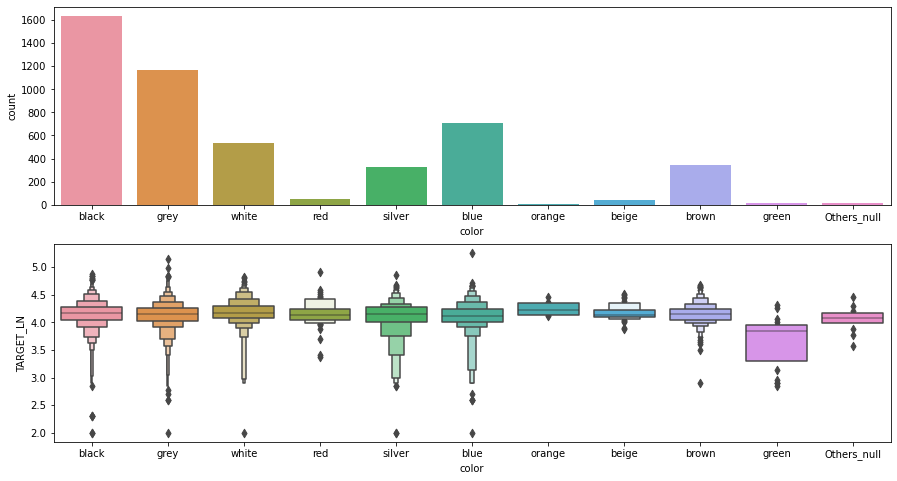

In [221]:
plot_cat_values(df, 'color', TARGET_LN)

In [180]:
# Podemos hacer OHE directo

### Tipo_coche

D:\DS\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


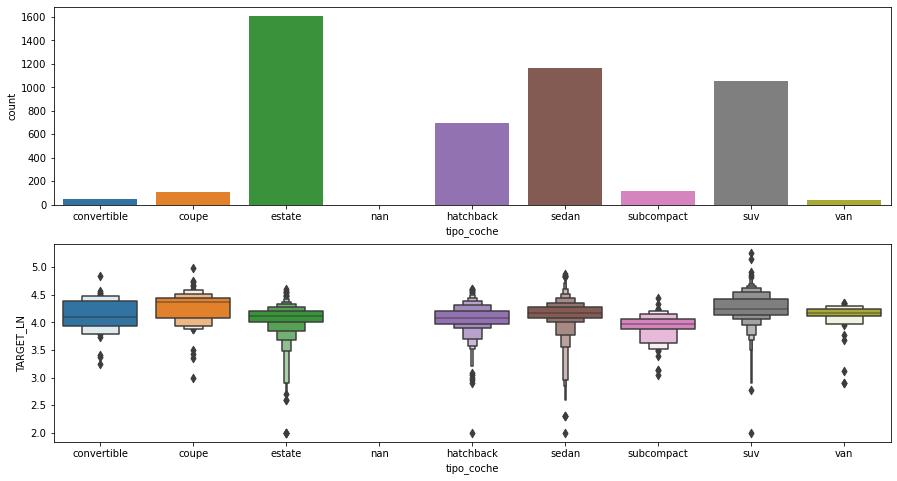

In [181]:
plot_cat_values(df, 'tipo_coche', TARGET_LN)

In [182]:
explore_cat_values(df, 'tipo_coche', TARGET_LN)

,n_rows,pct_rows,cars_bought,pct_cars_bought,mean_price_ln
tipo_coche,,,,,
convertible,47,0.009705,47,1.000000,4.125692
coupe,104,0.021474,103,0.990385,4.264275
estate,1604,0.331200,1599,0.996883,4.062663
hatchback,699,0.144332,699,1.000000,4.071932
sedan,1167,0.240966,1167,1.000000,4.141627
subcompact,113,0.023333,113,1.000000,3.935096
suv,1057,0.218253,1057,1.000000,4.264904
van,43,0.008879,43,1.000000,4.084499


In [183]:
df['tipo_coche'].isnull().sum()

9

In [184]:
df['tipo_coche'].value_counts(dropna = False)

estate         1604
sedan          1167
suv            1057
hatchback       699
subcompact      113
coupe           104
convertible      47
van              43
NaN               9
Name: tipo_coche, dtype: int64

In [185]:
df['tipo_coche'].fillna('Others_null', inplace = True)

## Dates

### Fecha_registro

In [186]:
df['fecha_registro'].dtype

dtype('O')

In [187]:
df['fecha_registro'] = pd.to_datetime(df['fecha_registro'])

In [188]:
df['year_registro'] = df['fecha_registro'].dt.year
df['month_registro'] = df['fecha_registro'].dt.month
df['day_registro'] = df['fecha_registro'].dt.day
df['weekday_registro'] = df['fecha_registro'].dt.weekday
df['quarter_registro'] = df['fecha_registro'].dt.quarter
df['week_registro'] = df['fecha_registro'].dt.week

C:\Users\JORDIG~1\AppData\Local\Temp/ipykernel_10392/3892546916.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_registro'] = df['fecha_registro'].dt.week


In [189]:
df.drop('fecha_registro', axis = 1, inplace = True)

### Fecha_venta 

In [190]:
df['fecha_venta'].dtype

dtype('O')

In [191]:
df['fecha_venta'] = pd.to_datetime(df['fecha_venta'])

In [192]:
df['year_venta'] = df['fecha_venta'].dt.year
df['month_venta'] = df['fecha_venta'].dt.month
df['day_venta'] = df['fecha_venta'].dt.day
df['weekday_venta'] = df['fecha_venta'].dt.weekday
df['quarter_venta'] = df['fecha_venta'].dt.quarter
df['week_venta'] = df['fecha_venta'].dt.week

C:\Users\JORDIG~1\AppData\Local\Temp/ipykernel_10392/387274857.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_venta'] = df['fecha_venta'].dt.week


In [193]:
df.drop('fecha_venta', axis = 1, inplace = True)

## Numericas

### km

In [194]:
df['km'].describe()

count    4.841000e+03
mean     1.409593e+05
std      6.020853e+04
min     -6.400000e+01
25%      1.028840e+05
50%      1.410800e+05
75%      1.752170e+05
max      1.000376e+06
Name: km, dtype: float64

In [195]:
df[df['km']<0]

,marca,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,...,day_registro,weekday_registro,quarter_registro,week_registro,year_venta,month_venta,day_venta,weekday_venta,quarter_venta,week_venta
2938,BMW,Others,-64.0,230.0,diesel,black,sedan,True,True,False,...,1.0,2.0,1.0,9.0,2018.0,4.0,1.0,6.0,2.0,13.0


<AxesSubplot:xlabel='modelo', ylabel='km'>

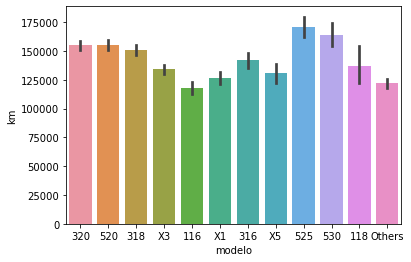

In [196]:
sns.barplot(data = df, x = 'modelo', y = 'km')

In [197]:
df[df['km']>0]['km'].mean()

140988.48491735538

In [198]:
df['km'] = np.where(df['km']<0,df[df['km']>0]['km'].mean(),df['km'])

In [199]:
df['km'].isnull().sum()

2

In [200]:
df['km'].fillna(df[df['km']>0]['km'].mean(), inplace = True)

### Potencia

In [201]:
df['potencia'].describe()

count    4842.000000
mean      128.981826
std        38.994839
min         0.000000
25%       100.000000
50%       120.000000
75%       135.000000
max       423.000000
Name: potencia, dtype: float64

In [202]:
df['potencia'].isnull().sum()

1

In [203]:
df['potencia'].fillna(df['potencia'].mean(), inplace = True)

## Boolean

### volante_regulable

In [204]:
df['volante_regulable'].value_counts(dropna=False)

True     2662
False    2177
NaN         4
Name: volante_regulable, dtype: int64

In [205]:
df['volante_regulable'].fillna(False, inplace = True)

### aire_acondicionado

In [206]:
df['aire_acondicionado'].value_counts(dropna=False)

True     3837
False    1004
NaN         2
Name: aire_acondicionado, dtype: int64

In [207]:
df['aire_acondicionado'].fillna(False, inplace = True)

### camara_trasera

<AxesSubplot:xlabel='camara_trasera', ylabel='count'>

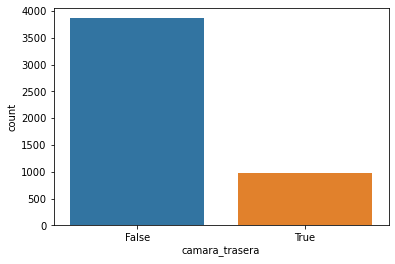

In [208]:
sns.countplot(data = df, x = 'camara_trasera')

In [209]:
df['camara_trasera'].isnull().sum()

2

In [210]:
df['camara_trasera'].fillna(True, inplace = True)

### asientos_traseros_plegables

In [211]:
df['asientos_traseros_plegables'].value_counts(dropna = False)

False    3877
True      962
NaN         4
Name: asientos_traseros_plegables, dtype: int64

In [212]:
df['asientos_traseros_plegables'].fillna(True, inplace = True)

### elevalunas_electrico

In [213]:
df['elevalunas_electrico'].value_counts(dropna = False)

False    2612
True     2229
NaN         2
Name: elevalunas_electrico, dtype: int64

In [214]:
df['elevalunas_electrico'].fillna(True, inplace = True)

### bluetooth

In [215]:
df['bluetooth'].value_counts(dropna = False)

False    3670
True     1169
NaN         4
Name: bluetooth, dtype: int64

In [216]:
df['bluetooth'].fillna(True, inplace = True)

### gps

In [217]:
df['gps'].value_counts(dropna=False)

True     4514
False     329
Name: gps, dtype: int64

### alerta_lim_velocidad

In [224]:
df['alerta_lim_velocidad'].value_counts(dropna = False)

True     2618
False    2223
NaN         2
Name: alerta_lim_velocidad, dtype: int64

In [225]:
df['alerta_lim_velocidad'].fillna(False, inplace = True)

# DataFrame Final

In [226]:
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
km,4843.0,140988.484917,60161.965598,476.0,102988.500000,141068.000000,175195.500000,1.000376e+06
potencia,4843.0,128.981826,38.990812,0.0,100.000000,120.000000,135.000000,4.230000e+02
precio,4837.0,15831.920612,9222.630708,100.0,10800.000000,14200.000000,18600.000000,1.785000e+05
TARGET_LN,4837.0,4.128839,0.281963,2.0,4.033424,4.152288,4.269513,5.251638e+00
year_registro,4842.0,2012.467369,2.527246,1990.0,2012.000000,2013.000000,2014.000000,2.017000e+03
month_registro,4842.0,6.131764,3.315159,1.0,3.000000,6.000000,9.000000,1.200000e+01
day_registro,4842.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000e+00
weekday_registro,4842.0,3.007641,2.023653,0.0,1.000000,3.000000,5.000000,6.000000e+00
quarter_registro,4842.0,2.393639,1.097379,1.0,1.000000,2.000000,3.000000,4.000000e+00
week_registro,4842.0,24.013011,14.610386,1.0,9.000000,22.000000,36.000000,5.300000e+01


In [227]:
df.describe(exclude = np.number).T

,count,unique,top,freq
marca,4843,1,BMW,4843
modelo,4843,12,Others,870
tipo_gasolina,4843,3,diesel,4631
color,4843,11,black,1632
tipo_coche,4843,9,estate,1604
volante_regulable,4843,2,True,2662
aire_acondicionado,4843,2,True,3837
camara_trasera,4843,2,False,3864
asientos_traseros_plegables,4843,2,False,3877
elevalunas_electrico,4843,2,False,2612


In [228]:
def OHE(dataframe, column):
  dummies_ds = pd.get_dummies(dataframe[column], prefix = column)
  dataframe = pd.concat([dataframe, dummies_ds], axis = 1)
  return dataframe.drop(column, axis = 1)

In [229]:
for col in df.describe(include = np.object).columns:
  df = OHE(df, col)

C:\Users\JORDIG~1\AppData\Local\Temp/ipykernel_10392/4194365281.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for col in df.describe(include = np.object).columns:


In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   modelo                       4843 non-null   category
 1   km                           4843 non-null   float64 
 2   potencia                     4843 non-null   float64 
 3   tipo_gasolina                4843 non-null   category
 4   volante_regulable            4843 non-null   bool    
 5   aire_acondicionado           4843 non-null   bool    
 6   camara_trasera               4843 non-null   bool    
 7   asientos_traseros_plegables  4843 non-null   bool    
 8   elevalunas_electrico         4843 non-null   bool    
 9   bluetooth                    4843 non-null   bool    
 10  gps                          4843 non-null   bool    
 11  alerta_lim_velocidad         4843 non-null   bool    
 12  precio                       4837 non-null   float64 
 13  TAR